We start by importing the proper packages and functions. 

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice, MockDevice, DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform, CompositeWaveform
from pulser_simulation import QutipEmulator, SimConfig
import qutip
from scipy.spatial.distance import pdist, squareform
from dataclasses import replace

# Intro to Pulser

Pulser is an ensemble of librairies for designing and simulating pulse sequences that are used to control neutral atom quantum computers (NAQCs), which are promising platforms for quantum computation and quantum simulation.

<center><img src="../images/pulser.png" width="1200"/></center>

In Pulser, a quantum information processing program is build very "physically". At the core lies the `Sequence` object, which is formed of:
- A `Device`, which can be virtual or a real device, with some given hardware constraints and a set of available laser channels. These channels can either be local (with a given target), which helps run digital algorithms, or they can be global, where the laser field acts on all neutral atoms.
- A `Pulse`, which is a set of time-varying waveforms for the laser's amplitude ($\Omega(t)$), detuning ($\delta(t)$) and phase ($\phi$, fixed for a given pulse). Each pulse has a given duration $T$.
- A `Register`, which is a dictionary of the atoms we have available in our system that will serve as qubits, and their coordinates. You can specify a new register by feeding in a list of coordinates.

Once a `Sequence` is formed, you can emulate it using the `QutipEmulator` function, which will return the final result of your quantum program running on this register of atoms. If you had access to a NAQC, you would send the `Sequence` object to be run on it!

In the following sections, you will play with the different features of Pulser for both digital and analog mode.

The following sections are named for their corresponding sections in the PPT slides. 

# Section 3: Single qubit gates using laser pulses

In this section, we demonstrate the flexibility of Pulser to implement single qubit rotations. Our aim is to first use the `rydberg_local` channel, which uses the set of states $\{|g\rangle, |r\rangle\}$ to encode our two qubit states. Transitions between these levels can be addressed with a single laser, leading to:

<center><img src="../images/energy_levels_rydberg.png" width="500"/></center>

We act on this two-level system using a on-resonance pulse ($\delta = 0$), with a fixed phase, and control the area under the pulse $\theta = \int_0^\tau \Omega(t) dt$. For this, we will create a register `reg` with a single qubit, and initiate the `seq` object for the `Sequence`. We have to declare the channel we will use when we try to apply the pulse on the system; we use the `rydberg_local` channel which we name `ch0` for brevity. We can then generate a pulse with a fixed area `theta` and duration `duration` using the `BlackmanWaveform` function. After adding this pulse to our sequence `seq`, we draw it.

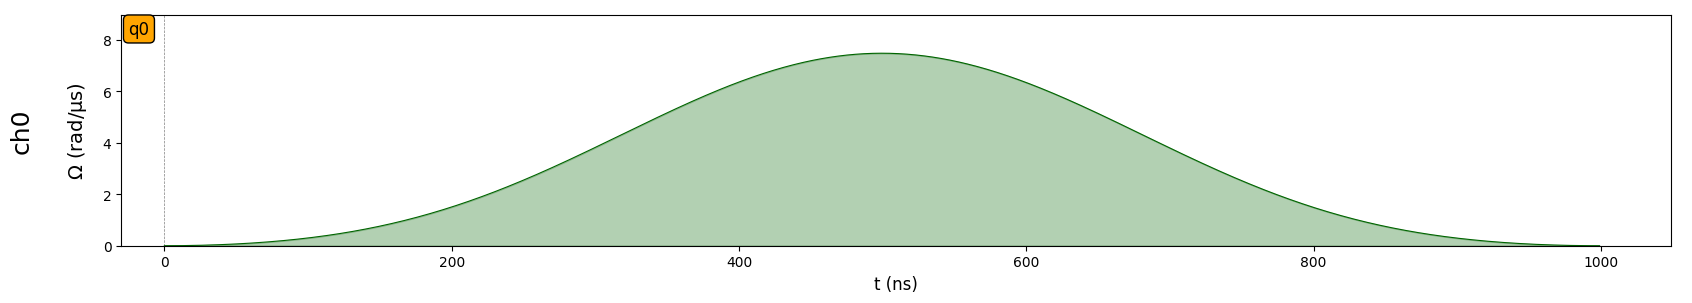

In [3]:
device_used = MockDevice #we define the virtual device we will use for this simple demonstration.
reg = Register({"q0": (0, 0)})
seq = Sequence(reg, device_used)
seq.declare_channel("ch0", "rydberg_local", initial_target="q0")

duration = 1000 #duration of the pulse
theta = np.pi #angle of rotation
phase = 0 # phase of pulse, defines the axis of rotation
waveform = BlackmanWaveform(duration, theta)  # Duration: 1us, Area: theta
pulse = Pulse.ConstantDetuning(waveform, detuning=0, phase = phase)
seq.add(pulse, "ch0")  # The first pulse


seq.draw(draw_phase_curve=True)


We then simulate the sequence using the local emulator `QutipEmulator`. 

In [6]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run(progress_bar=True)

10.1%. Run time:   0.01s. Est. time left: 00:00:00:00
20.1%. Run time:   0.01s. Est. time left: 00:00:00:00
30.1%. Run time:   0.02s. Est. time left: 00:00:00:00
40.1%. Run time:   0.03s. Est. time left: 00:00:00:00
50.0%. Run time:   0.03s. Est. time left: 00:00:00:00
60.0%. Run time:   0.04s. Est. time left: 00:00:00:00
70.0%. Run time:   0.05s. Est. time left: 00:00:00:00
80.0%. Run time:   0.06s. Est. time left: 00:00:00:00
90.0%. Run time:   0.06s. Est. time left: 00:00:00:00
Total run time:   0.07s


Our final result is stored in `results`, which is a `qutip.QObj` object, and corresponds to the complex wavefunction obtained at the end of the quantum process. We then sample randomly this wavefunction by repeatedly collapsing it into the computational basis. This results in a `Counter` object which is just a big dictionary of bitstrings (where $|0\rangle \equiv |g\rangle$ and $|1\rangle \equiv |r\rangle$), where each has an associated count. We can plot the bitstring distribution.

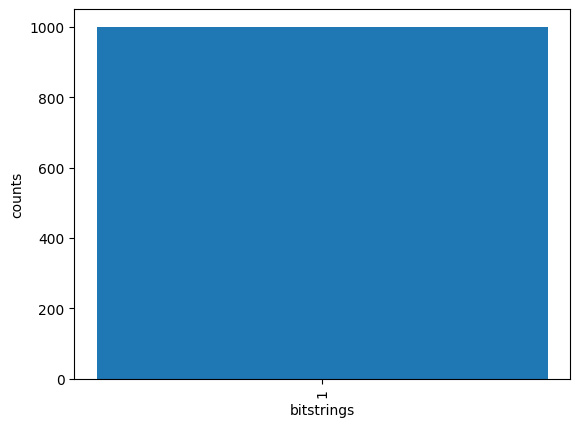

In [4]:
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples} #filter the Counter dictionary so as not to show the infrequent bitstrings
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

In this case, the result is trivial: with $100\%$ probability, we flipped the $|0\rangle$ state to the $|1\rangle$ excited state! I encourage you to test other angles $\theta$ and phase $\phi$ in order to see the result (for example, $\theta = \pi/2$). Notice that, since we collapse on the Rydberg basis, we cannot distinguish states such as $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ and $\frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$ - they would both appear with a $50%$ distribution of both $0,1$.

We then play around with a series of pulses. Again, we define our register and device. We set the same duration for all pulses in this simple setting. We define `param_list` as a list of tuples of $(\phi_p, \theta_p)$ which are all applied consecutively on our test atom. This is akin to doing $\Psi_f = U |0\rangle$, wher

$$U = \prod_{p} R_{e(\phi_p)} (\theta_p)$$

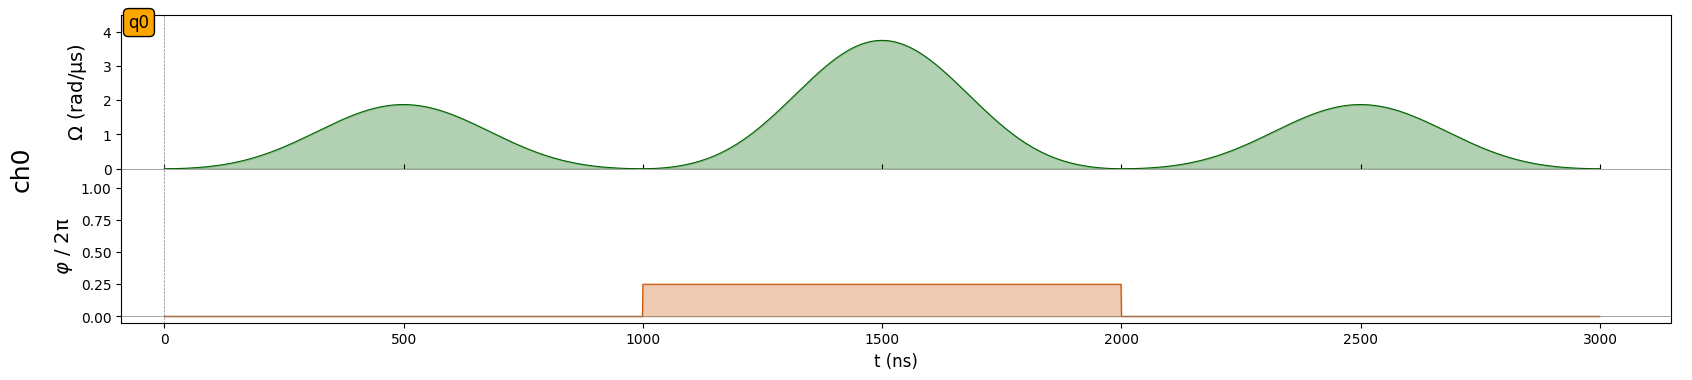

In [7]:
reg = Register({"q0": (0, 0)})
seq = Sequence(reg, device_used)
seq.declare_channel("ch0", "rydberg_local", initial_target="q0")

duration = 1000 #duration of the pulse
param_list = [(0, np.pi/4), (np.pi/2, np.pi/2), (0, np.pi/4)]  #phi/theta tuples
for param in param_list:
    phase, theta = param
    waveform = BlackmanWaveform(duration, theta)  # Duration: 1us, Area: theta
    pulse = Pulse.ConstantDetuning(waveform, detuning=0, phase = phase)
    seq.add(pulse, "ch0")  # The first pulse

seq.draw(draw_phase_curve=True)

Again, we emulate the result and plot the bitstring distribution.

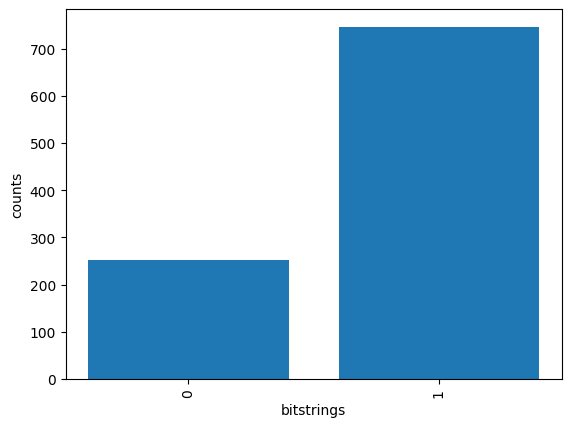

In [8]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
results = simul.run(progress_bar=False)
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

We can visualize the sequence $[(0, \pi/4), (\pi/2, \pi/2), (0, \pi/4)]$ as

<center><img src="../images/qubit_rotation.png" width="200"/></center>

An we see that the bitstring distribution is exactly as we expected it. If you attempt to implement other sequences of pulses, you can play with this visualization website [text](https://bloch.kherb.io/.) to see the path on the Bloch sphere.


## Applying single qubit rotation on multiple qubits

We can also change the channel to `raman_local`, which is what one would use for a digital implementation. This channel offers a laser that the two levels $|g\rangle$ and $|h \rangle$ (for "ground" and "hyperfine", respectively). The implementation is the same as before, we only need to change the "declared channel". In this example, we further show how you can apply these two pulses to two atoms simultaneously. Note that, if you were to repeat this cell with the `rydberg_local` channel, you would find a different answer. This is because the  $|g\rangle$ and $|h \rangle$ do not interact with one another so we can manipulate them independently. On the other hand, in the `rydberg` basis, the excited states $|r_i\rangle$ interact with one another! This is the basis of the Rydberg blockade, which we will explore in the next section.

The three levels $|g\rangle$, $|h \rangle$ and $|r \rangle$ can be visualized as:

<center><img src="../images/three_states.png" width="120"/></center>

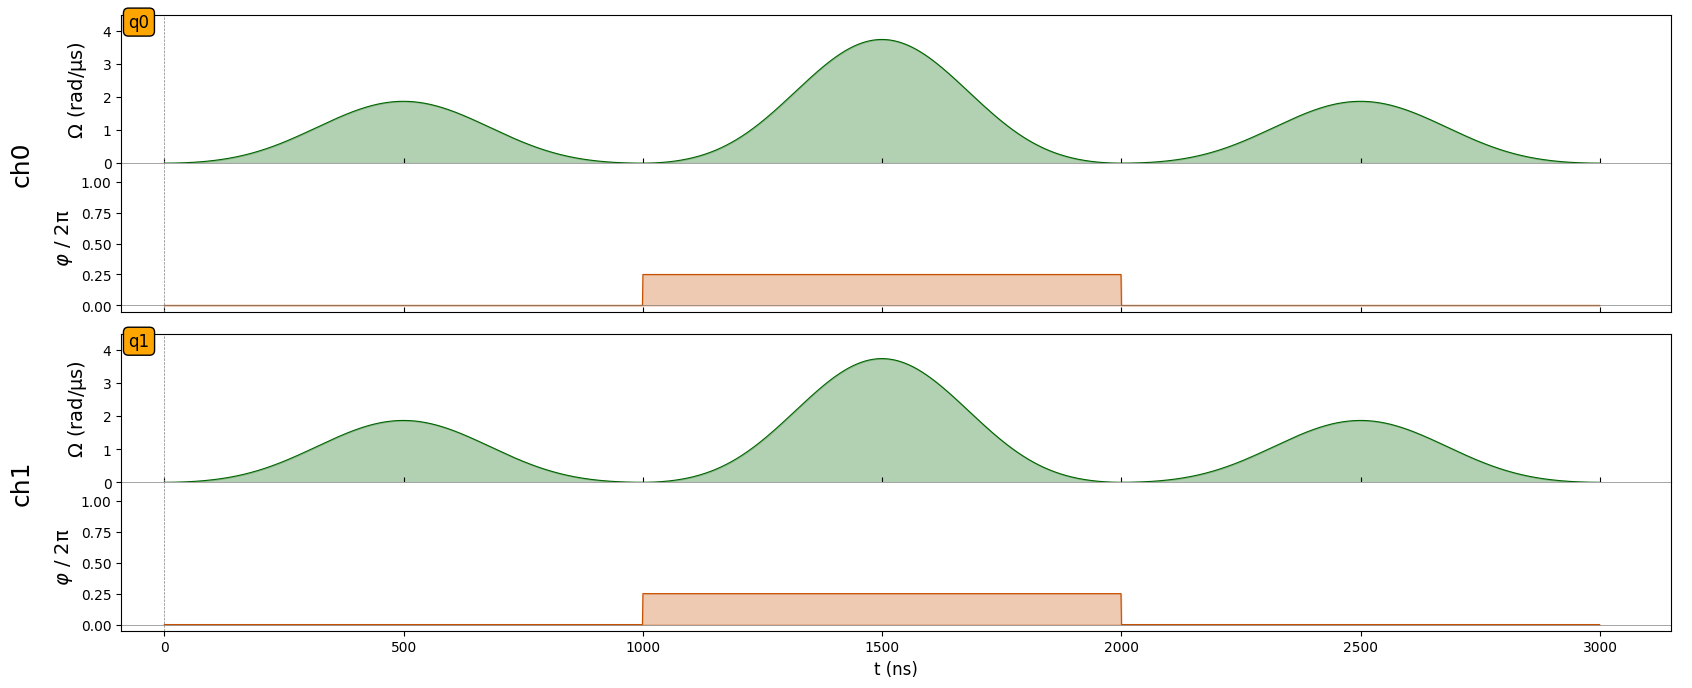

In [11]:
# basis = 'raman_local'
basis = 'rydberg_local'
distance = 3
reg = Register({"q0": (0, 0), "q1" : (distance,0)})
seq = Sequence(reg, device_used)
seq.declare_channel("ch0", basis, initial_target="q0")
seq.declare_channel("ch1", basis, initial_target="q1")


duration = 1000 #duration of the pulse
param_list = [(0, np.pi/4), (np.pi/2, np.pi/2), (0, np.pi/4)]  #phi/theta tuples
for param in param_list:
    phase, theta = param
    waveform = BlackmanWaveform(duration, theta)  # Duration: 1us, Area: theta
    pulse = Pulse.ConstantDetuning(waveform, detuning=0, phase = phase)
    seq.add(pulse, "ch0")  # The first pulse
    seq.add(pulse, "ch1")  # The first pulse

seq.draw(draw_phase_curve=True)

Then, we emulate the sequence and plot the bitstring distribution.

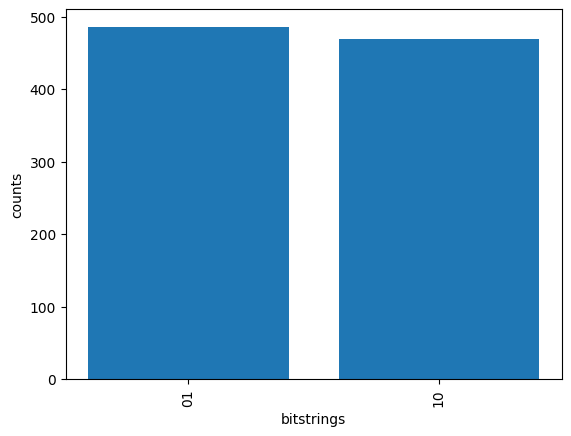

In [12]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
results = simul.run(progress_bar=False)
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

Note that, if the channel is `raman_local`, changing the distance between the atoms `q0` and `q1` does not change the state at the end. This is because the raman states (hyperfine states) do not interact with one another - never did we excite the atoms to the strongly interacting Rydberg state. If you change the basis to `rydberg_local`, you should find much stranger results...

# Section 4: The Rydberg blockade effect

We saw in the previous section that if we try to send arbitrary pulses on atoms in the `rydberg` basis, we get confusing answers. This is because atoms in the excited Rydberg state have a *repulsive* interaction between themselves. For two atoms $1,2$, the interaciton hamiltonian is given by $H_{Ryd}/\hbar = \frac{C_6}{r_{12}^6} n_1 n_2$ where $n_i = |r_i\rangle \langle r_i|$. This interaction decreases very fast ($1/r^6$ with $r$ the distance between two atoms), but for short distances, it acts to shift the local energy levels and *prohibits* double occupancy of the Rydberg excited state.

<center><img src="../images/blockade.png" width="500"/></center>

This is a dynamic effect: it depends on the intensity of the on-resonance laser field $\Omega$ we shine on the atoms. In this regard, a finite $\Omega$ with generate a certain blockade radius $R_b = (C_6/\Omega)^{1/6}$, such that, if $R_{interatomic} > R_b$, we can generate any state we want. However, if $R_{interatomic} < R_b$, the state $|rr>$ is energetically forbidden (blockaded) and one gets an entangled state.

In this experiment, we send a global on-resonance pulse with $\theta = \pi$, $\phi = 0$, which is like a $R_x(\pi)$. This will attempt to put all qubits on in the $|1\rangle = |r\rangle$ state. This is done through the `run_RX_on_atom_pair` function. We then change the distance between atoms, and plot the distribution on the obtained bitstrings.

In [13]:
#Unknown if I should keep this cell
Omega_max = AnalogDevice.channels['rydberg_global'].max_amp
try:
    R_blockade = AnalogDevice.rydberg_blockade_radius(Omega_max) #obtain the blockade radius from the Omega max
except:
    R_blockade = None

print(f"Blockade Radius is: {R_blockade}µm.")


Blockade Radius is: 6.402675875387433µm.


In [41]:
def run_RX_on_atom_pair(R_interatomic, param = (0, np.pi)):
    """
    input:
    R_interatomic : distance between atoms 
    param: tuple of (phi, theta) for the on-resonance pulse
    output:
    sequence, results
    """
    q_dict = {
        "q0": np.array([-R_interatomic/2, 0.0]),
        "q1": np.array([R_interatomic/2, 0.0]),
    }
    reg = Register(q_dict)

    seq = Sequence(reg, device_used)
    seq.declare_channel("ryd", "rydberg_global")
    duration = 300 #duration of the pulse
    phase, theta = param
    amp_wf = BlackmanWaveform(duration, theta)  # Duration: 1us, Area: theta
    detuning_wf = ConstantWaveform(duration, 0.0)

    pulse = Pulse(amp_wf, detuning_wf, phase=phase)
    seq.add(pulse, "ryd")  # The first pulse

    simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
    results = simul.run(progress_bar=False)
    return seq, results



We can plot the generated sequence for a given `R_interatomic` and `param`, as well as the bitstring counts.

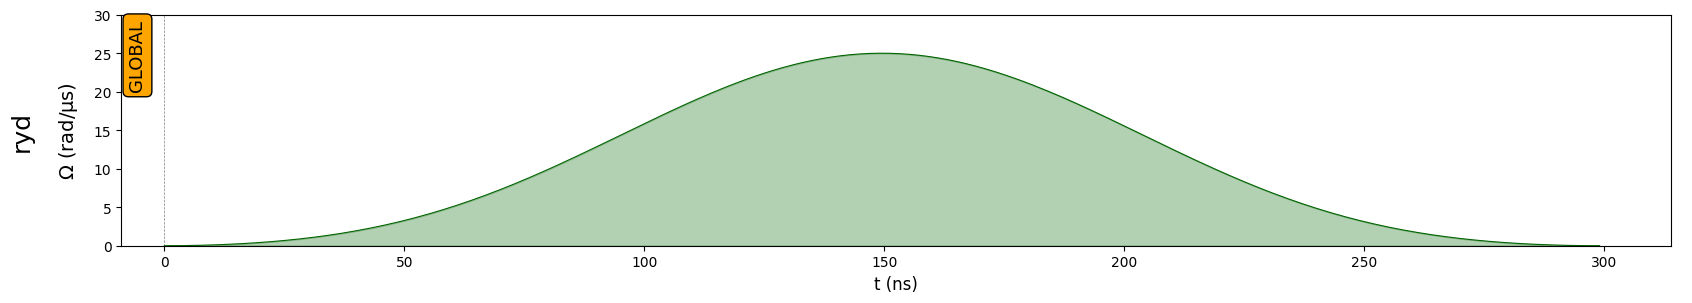

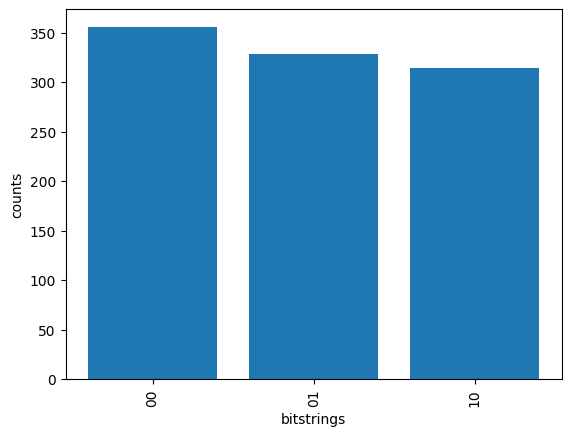

In [42]:
seq, results = run_RX_on_atom_pair(R_interatomic = 6, param = (0, np.pi))
seq.draw()
count_dict = results.sample_final_state(N_samples=1000)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()


We compute the function for 12 distances between $5 \mu m$ and $12 \mu m$. We store the count of each of the possible bitstrings (see the `strings`).

In [43]:
distances = np.linspace(5, 14, 12)
data = np.zeros((4, len(distances)))
strings = ['00', '01', '10', '11']
for n in range(len(distances)):
    dist = distances[n]
    _, results = run_RX_on_atom_pair(R_interatomic = dist, param = (0, np.pi))
    count_dict = results.sample_final_state(N_samples=1000)
    res_dict = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
    for i in range(4):
        data[i, n] = res_dict.get(strings[i], 0)/1000
        

We plot the expectation value of each of the four bitstrings as a function of the interatomic distance.

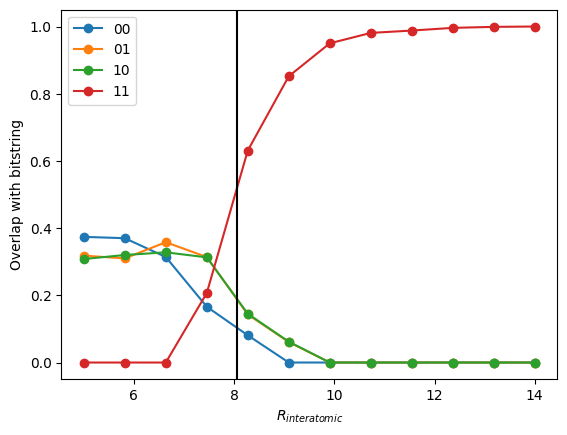

In [44]:
for i in range(4):
    plt.plot(distances, data[i,:], 'o-', label = strings[i])
plt.xlabel(r'$R_{interatomic}$')
plt.ylabel('Overlap with bitstring');
plt.axvline(x = AnalogDevice.rydberg_blockade_radius(np.pi), color = 'black') #this calculates the Rydberg blockade radius
plt.legend()

Here, the blockade radius is dictated by the $\Omega_{eff} = \theta/t = \pi \; \text{rad}/\mu s$ of the fixed duration, fixed area pulse. This sets $R_b \sim 8 \mu m$. You can see that, for $R < R_b$, the $|11\rangle$ is unoccupied, and we create a superposition $\psi_{mix} = \alpha |00\rangle + \beta |01\rangle + \gamma |10\rangle$, with $|\alpha| = |\beta| = |\gamma|$. For $R > R_b$, the $|11\rangle$ is the only occupied state - our $R_X(\pi)$ has produced the desired effect.

In order to forbid the state $|00> = |gg>$ state to be present at short distances (a byproduct of the on-resonance pulse), we would need to include some off-resonance modulation of the pulse. You can play with this by replaceing the `detuning_wf` line by:

```python
first = -BlackmanWaveform(duration/2, np.pi)
second = BlackmanWaveform(duration/2, np.pi)
detuning_wf = CompositeWaveform(first, second)
```

This waveform is chosen such that the area under the detuning waveform is $0$. This detuning modulation helps to force atoms in the excited state at the end of the pulse. Note that, however, the system now has a new $\Omega_{eff} (t) = \sqrt{\Omega(t)^2 + \delta(t)^2}$ so it is harder to predict the Blockade radius from such an implementation. In order to not have blockade radius that changes with the pulse shape you send, one generally tries to forbid the  $|00> = |gg>$ state by using the $|g\rangle$, $|h \rangle$ and $|r\rangle$ basis as in the digital implementation - this is actually how we make a CZ gate! The important feature is that is uses the Rydberg blockade phenomena to generate entangles states such as Bell pairs, and we use local digital rotations in the `raman` basis to control more precisely the state.

# Section 5: CZ gates with global pulses

In this section we show how to prepare the pulse sequence that generates a *Controlled - Z* gate. We will prepare our state with atoms in any of the "digital" states that we shall call $|g\rangle$ and $|h \rangle$ (for "ground" and "hyperfine", respectively). Then we will use the *Rydberg blockade* effect to create the logic gate. The levels that each atom can take are the following: 

<center><img src="../images/three_states.png" width="120"/></center>

We first extract the Blockade radius of the DigitalAnalogDevice which we will use.

In [45]:
device_used = DigitalAnalogDevice

Omega_max = device_used.channels['rydberg_global'].max_amp #maximum allowed Rabi amplitude on the device_used
try:
    R_blockade = device_used.rydberg_blockade_radius(Omega_max) #obtain the blockade radius from the Omega max
except:
    R_blockade = None

print(f"Blockade Radius is: {R_blockade}µm.")


Blockade Radius is: 8.374946061705455µm.


Then, we create a register with two atoms such that their interactomic distance is well within the Blockade radius.

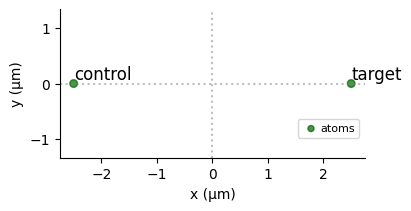

In [46]:
# Atom Register and Device
R_interatomic = 5
q_dict = {
    "control": np.array([-R_interatomic/2, 0.0]),
    "target": np.array([R_interatomic/2, 0.0]),
}
reg = Register(q_dict)
reg.draw()

Then, in order to test the CZ gate's performance, we need to prepare specific initial states on which the CZ will act. At the beginning of any sequence, the atoms are all in the $|0\rangle$ state. In order to set some of them to the $|1\rangle \equiv |h\rangle$ state, we apply local $R_Y (\pi)$ pulses on the atoms. The `preparation_sequence` function takes in a string such as `"hh"` or `"hg"` and return the state preparation sequence. Note that the qubit 0 is the control, while qubit 1 is the target.

In [49]:
def preparation_sequence(state_id, reg):
    duration = 300 #duration of the Ry pulses
    pi_Y = Pulse.ConstantDetuning(
        BlackmanWaveform(duration, np.pi), 0.0, -np.pi / 2
    )
    seq = Sequence(reg, MockDevice)
    seq_dict = {"1": "target", "0": "control"}
    seq.declare_channel("target", "raman_local", initial_target="target")
    seq.declare_channel("control", "raman_local", initial_target="control")
    for k in range(len(reg.qubits)):
        if state_id[k] == 'h':
            seq.add(pi_Y, seq_dict[str(k)])

    return seq


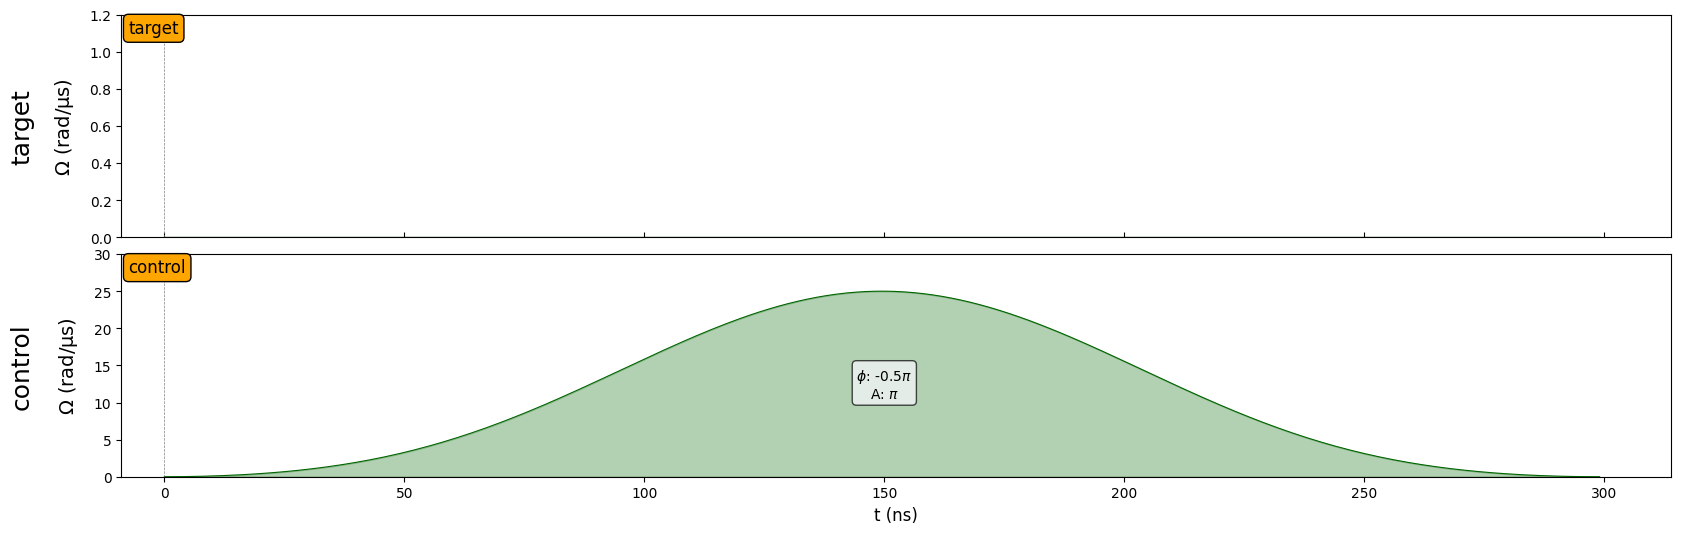

In [50]:
seq = preparation_sequence("hg", reg)
seq.draw(draw_phase_area=True)

The full CZ gate protocol is given by:

<center><img src="../images/cz_gate.png" width="1200"/></center>

The sequence of operation is known as the $\pi - 2\pi - \pi$. As you can see from the graph above, it will result in a phase being acquired between the $|11\rangle$ and the other states. We define this sequence below:

In [51]:
pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0.0, 0)
twopi_pulse = Pulse.ConstantDetuning(
    BlackmanWaveform(duration, 2 * np.pi), 0.0, 0
)

def CZ_sequence(initial_id, reg):
    # Prepare State
    seq = preparation_sequence(initial_id, reg)

    # Declare Rydberg channel
    seq.declare_channel("ryd", "rydberg_local", "control")

    # add CZ sequence:
    seq.add(
        pi_pulse, "ryd", "wait-for-all"
    )  # Wait for state preparation to finish.
    seq.target("target", "ryd")  # Changes to target qubit
    seq.add(twopi_pulse, "ryd")
    seq.target("control", "ryd")  # Changes back to control qubit
    seq.add(pi_pulse, "ryd")

    return seq

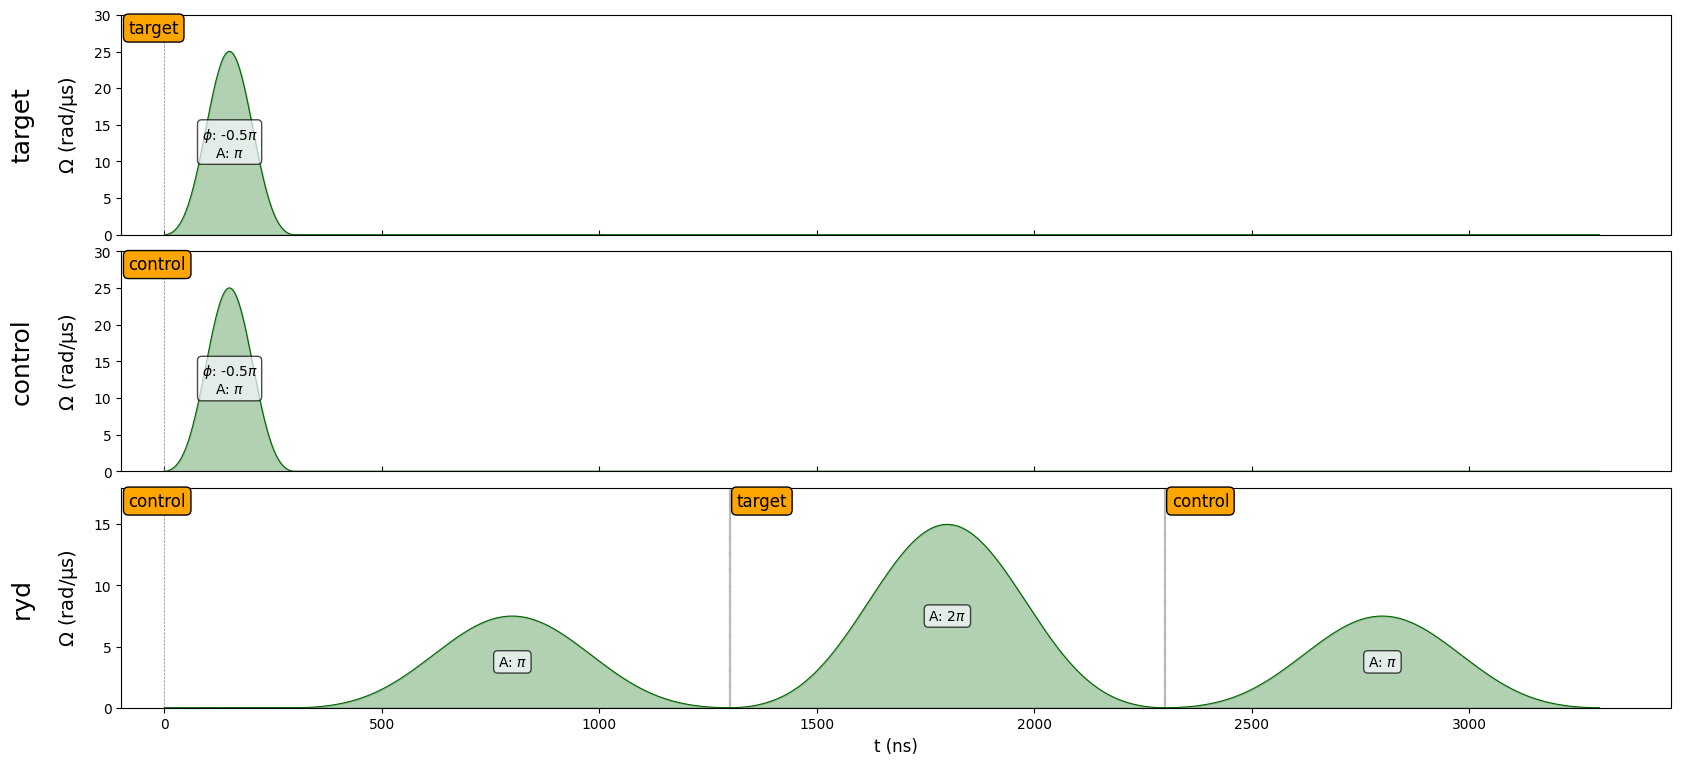

In [52]:
seq = CZ_sequence('hh', reg)
seq.draw(draw_phase_area=True)

We then prepare a function that returns a `qutip.tensor` object corresponding to the given state we want to measure. We will then be able to collapre the `result` obtained from our emulation on this tensor, in order to measure the overlap with a given state *and* its phase.

In [53]:
def qutip_state(state_id):
    if state_id == 'gg':
        ket = {
            op: qutip.basis(2, i)
            for i, op in enumerate('rg')
        }
        return qutip.tensor([ket[x] for x in state_id])
    else:
        ket = {
            op: qutip.basis(3, i)
            for i, op in enumerate('rgh')
        }
        return qutip.tensor([ket[x] for x in state_id])

For each of the initial state, we perform the CZ sequence, emulate the result, and perform the overlap with the `qutip.tensor` object. Since the emulator performs a full statevector emulation, we have the quantum state of the system at all times during the process. In a real quantum simulation, we could only observe shots in the computational basis, and it would be much harder to verify that we have effectively done a correct CZ (we would need to perform quantum state tomography).

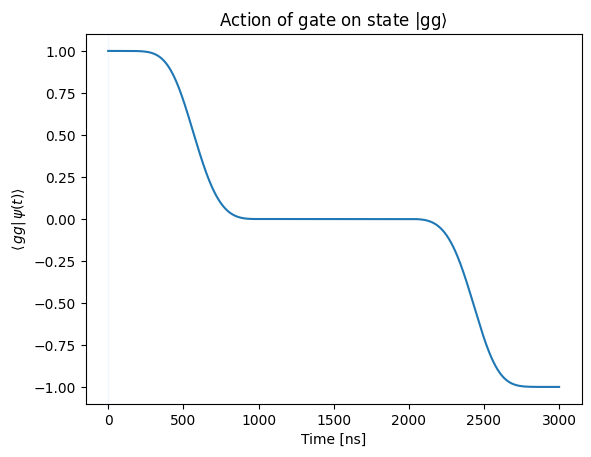

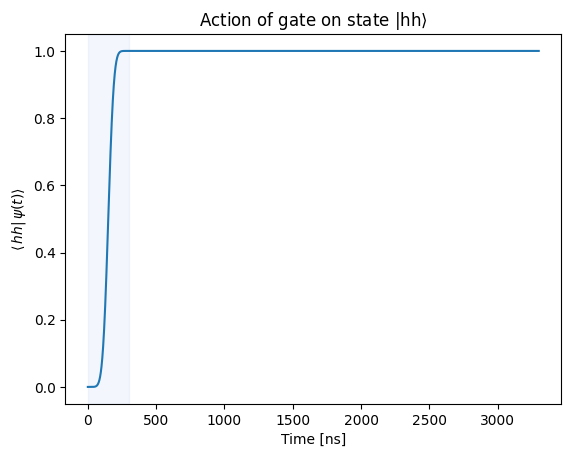

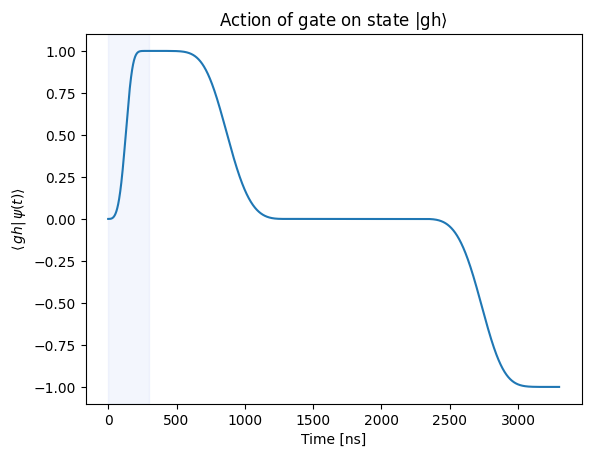

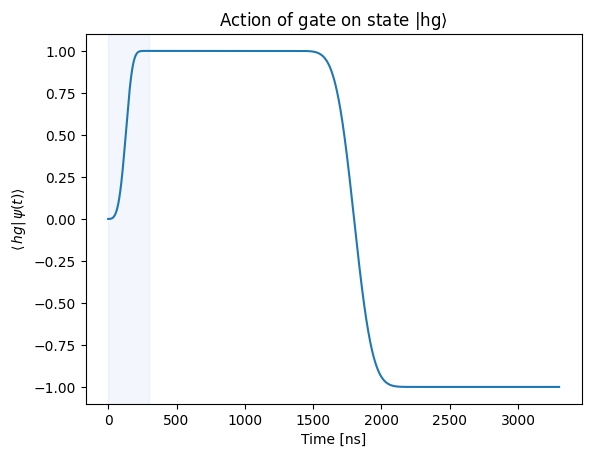

In [56]:
CZ = {}
for state_id in {"gg", "hg", "gh", "hh"}:
    # Get CZ sequence
    seq = CZ_sequence(
        state_id, reg
    )  # constructs seq

    # Construct Simulation instance
    simul = QutipEmulator.from_sequence(seq)
    res = simul.run()

    #get the qutip.tensor object for the initial state
    prep_state = qutip_state(state_id)
    #colored window for the state preparation
    prep_time = 300
    if state_id == 'gg':
        #if the initial state is 'gg' there is no preparation sequence
        prep_time = 0

    data = [st.overlap(prep_state) for st in res.states] #get the overlaps with prep_state

    final_st = res.states[-1]
    CZ[state_id] = final_st.overlap(prep_state) #store the final overlap

    #plot
    plt.figure()
    plt.plot(np.real(data))
    plt.xlabel(r"Time [ns]")
    plt.ylabel(rf"$ \langle\,{state_id} |\, \psi(t)\rangle$")
    plt.axvspan(0, prep_time, alpha=0.06, color="royalblue")
    plt.title(rf"Action of gate on state $|${state_id}$\rangle$")

In [57]:
CZ

{'gg': (-0.9987914999698044+0.04914813920385617j),
 'hh': (0.9999999993096721-3.673940394905827e-16j),
 'gh': (-0.9999999999461248+1.8369701986220654e-16j),
 'hg': (-0.999999999947262+1.8369701986241615e-16j)}

This is exactly as expected!

# Extra: W-states

A W-state is the generalization of a Bell state for $n$ qubits. This entangled state is given by 

$|W\rangle = \frac{1}{\sqrt{n}} ( |100\cdots 0\rangle + |010\cdots 0\rangle + \cdots + |00\cdots 01\rangle$

As can be seen, if one of the qubit is lost (measured or affected by noise), the rest of the system remains entangled. This robustness is a key difference with the GHZ state. 

We attempt to prepare this with $n$ atoms. For this purpose, we place all of the atoms in  all placed within the same Blockade radius, and act on them with along with a $\pi$ pulse with ramping detuning.

In [148]:
device_used = AnalogDevice
# device_used = replace(AnalogDevice, rydberg_level=70) #for large clusters (n > 5) we need to change the rydberg level

Omega_max = device_used.channels['rydberg_global'].max_amp
try:
    R_blockade = device_used.rydberg_blockade_radius(Omega_max) #obtain the blockade radius from the Omega max
except:
    R_blockade = None

print(f"Maximum Rabi amplitude available is: {Omega_max} rad/µs.")
print(f"Minimum blockade radius on this device is: {R_blockade}µm.")

Maximum Rabi amplitude available is: 12.566370614359172 rad/µs.
Minimum blockade radius on this device is: 6.402675875387433µm.


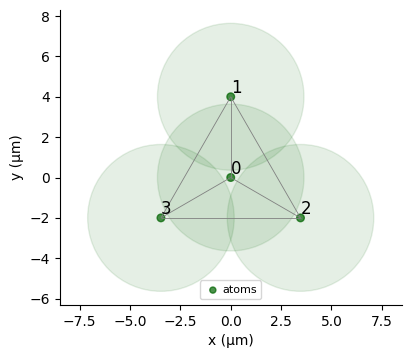

New Omega_max is: 5.8414337994317584 rad/µs.


In [165]:
n = 4
min_distance = 4 #this is optimistic - current devices have min_distance = 5
dist = min(R_blockade/2.1, 2.1*min_distance) #find the right distance for the register
coords = np.array([[0,0]] + [[dist*np.sin(2*np.pi*i/(n-1)), dist*np.cos(2*np.pi*i/(n-1))] for i in range(n-1)])
#rescale the coordinates - we need to enforce the minimum distance
factor = min_distance/min(pdist(coords))
coords *= factor
#now we check the max distance between atoms - our blockade radius needs to cover at least that
max_dist = max(pdist(coords))
#we check whether we need to rescale the blockade radius - the maximum of the two values it kept
R_blockade_new = max(1.05*max_dist, R_blockade)
#create the register
reg = Register.from_coordinates(coords=coords, center = True)
reg.draw(blockade_radius=R_blockade_new, draw_half_radius=True)

#compute the new omega_max from the new blockade radius
Omega_max_new = device_used.rabi_from_blockade(R_blockade_new)
print(f"New Omega_max is: {Omega_max_new} rad/µs.")

We perform a simple sequence with a constant pulse for $\Omega$, which continuously enforces the blockade of all the atoms, whicle the detuning is swept from large negative values to large positive values, thus enforcing the max occupancy of the excited Rydberg states at the end of the pulse (while maintaining the blockade).

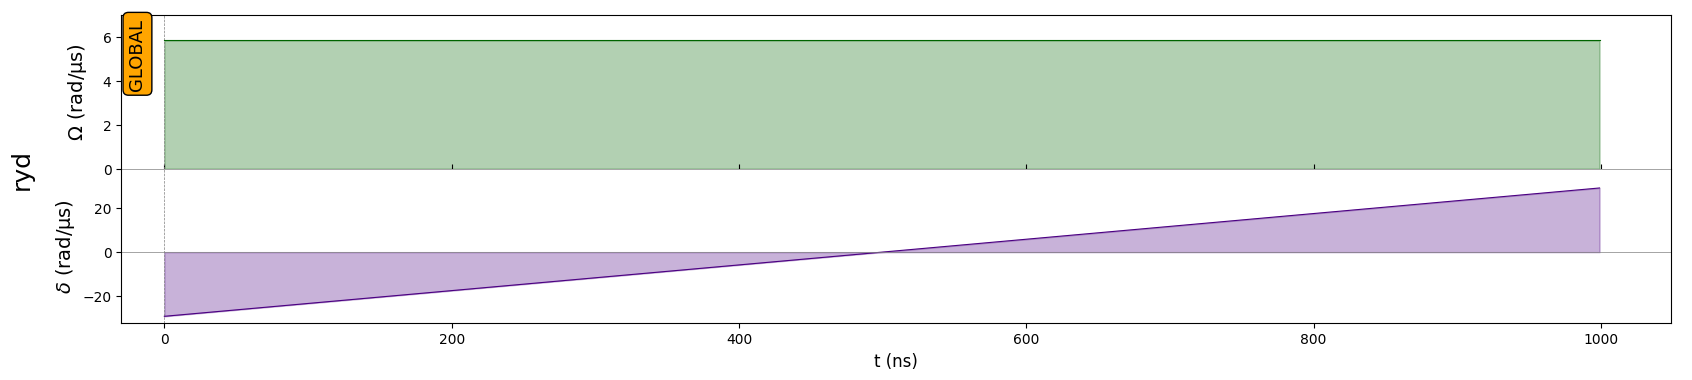

In [166]:
seq = Sequence(reg, MockDevice)
seq.declare_channel('ryd', 'rydberg_global')
duration = 1000
amp_wf = BlackmanWaveform(duration, np.pi)  
amp_wf = ConstantWaveform(duration, value = Omega_max_new)  # Constant pulse which enforces the blockade throughout: 1000ns, linear sweep from -20 to 20 rad/µs
detuning_wf = RampWaveform(amp_wf.duration, -5*Omega_max_new, 5*Omega_max_new)  # Duration: 1000ns, linear sweep from -20 to 20 rad/µs
complex_pulse = Pulse(amp_wf, detuning_wf, phase=0)

seq.add(complex_pulse, 'ryd')
seq.draw()



We perform the emulation an plot the distribution of bitstrings.

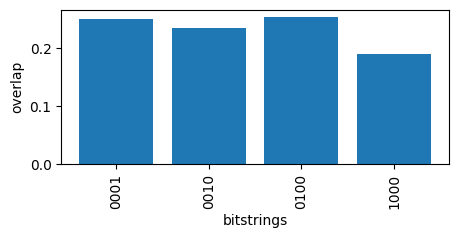

In [164]:
plt.figure(figsize=(5,2))
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                sampling_rate=1, #change the sampling of the wavefunction
                                with_modulation=False, #modulate the signal like a real device
                                )
results = simul.run(progress_bar=False)
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v/1000 for k, v in count_dict.items() if v > 0.05*N_samples}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('overlap')
plt.xlabel('bitstrings')
plt.show()